# Análisis exploratorio de los datos

RESUMEN DESCRIPTIVO: 

El conjunto de datos contiene información de la Oficina de Evaluadores de Ames utilizada para calcular los valores evaluados de propiedades residenciales individuales vendidas en Ames, IA desde 2006 hasta 2010. Referencia: Ames Iowa: Alternativa al conjunto de datos de viviendas de Boston, Decock, 2011.

FUENTES: 

Oficina de Evaluadores de Ames, Iowa

DESCRIPCIÓN DE VARIABLES:

Los datos tienen 82 columnas que incluyen 23 variables nominales, 23 ordinales, 14 discretas y 20 continuas (y 2 identificadores de observación adicionales).


In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

DATA_PATH = Path("../data/")
file_path = DATA_PATH / "raw/Housing.txt"



In [2]:
df_housing = pd.read_csv(file_path, sep="\t")
df_housing.info()

<class 'pandas.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   str    
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   str    
 7   Alley            198 non-null    str    
 8   Lot Shape        2930 non-null   str    
 9   Land Contour     2930 non-null   str    
 10  Utilities        2930 non-null   str    
 11  Lot Config       2930 non-null   str    
 12  Land Slope       2930 non-null   str    
 13  Neighborhood     2930 non-null   str    
 14  Condition 1      2930 non-null   str    
 15  Condition 2      2930 non-null   str    
 16  Bldg Type        2930 non-null   str    
 17  House Style      2930 non

## 1. Definición del Problema de Clasificación

### Opción A: Basado en Precio de Venta
**Objetivo:** Clasificar inmuebles en categorías de "Alto Valor" vs "No Alto Valor" basándose en el precio de venta (SalePrice) a través de un umbral(por ejemplo, 80-85 percentil) para definir "Alto Valor".

- Beneficios:
  - Directamente relacionado con el valor monetario
  - Fácil de interpretar para stakeholders

- Limitaciones:
  - Fluctuaciones del mercado pueden afectar la definición de "Alto Valor"
  - No considera características intrínsecas de la propiedad


### Opción B: Score Compuesto

**Objetivo:** Clasificar inmuebles en categorías de "Alto Valor" vs "No Alto Valor" basándose en un score compuesto que considera múltiples dimensiones de calidad y características físicas.

### Justificación

El precio de venta (SalePrice) por sí solo puede ser engañoso debido a:
- Fluctuaciones del mercado temporal
- Ventas anormales (foreclosures, ventas familiares)
- Diferencias en condiciones de venta

Un **score compuesto** basado en características intrínsecas de la propiedad proporciona:
1. Mayor estabilidad temporal
2. Mejor generalización a nuevos mercados
3. Interpretabilidad para tasadores y agentes inmobiliarios

- Limitaciones:
  - Requiere definición cuidadosa de las dimensiones y pesos.
  - Puede ser más complejo de comunicar a stakeholders no técnicos.

### Componentes del Score Compuesto

Basándome en el diccionario de datos, propongo 4 dimensiones principales:

#### 1. **Calidad General** (35% del score)
- `Overall Qual` (1-10): Calidad de materiales y acabados
- `Overall Cond` (1-10): Condición general de la casa

#### 2. **Tamaño y Espacios** (30% del score)
- `Gr Liv Area`: Área de vivienda sobre el nivel del suelo
- `Total Bsmt SF`: Área total del sótano
- `Garage Area`: Área del garaje
- `Lot Area`: Tamaño del lote

#### 3. **Ubicación Premium** (20% del score)
- `Neighborhood`: Barrios de alto valor
- `MS Zoning`: Zonificación (densidad residencial)

#### 4. **Características Premium** (15% del score)
- `Kitchen Qual`: Calidad de cocina
- `Exter Qual`: Calidad exterior
- `Bsmt Qual`: Calidad del sótano
- `Garage Cars`: Capacidad del garaje
- `Fireplaces`: Número de chimeneas
- `Full Bath`: Baños completos


### Exploración Inicial de Variables Clave

In [3]:
# Variables clave para el score compuesto
key_vars = {
    'calidad': ['Overall Qual', 'Overall Cond'],
    'tamano': ['Gr Liv Area', 'Total Bsmt SF', 'Garage Area', 'Lot Area'],
    'ubicacion': ['Neighborhood', 'MS Zoning'],
    'premium': ['Kitchen Qual', 'Exter Qual', 'Bsmt Qual', 'Garage Cars', 'Fireplaces', 'Full Bath']
}

# Inspeccionar datos básicos
print("=" * 80)
print("INFORMACIÓN DEL DATASET")
print("=" * 80)
print(f"Total de observaciones: {len(df_housing):,}")
print(f"Total de variables: {df_housing.shape[1]}")
print(f"\nRango de precios: ${df_housing['SalePrice'].min():,.0f} - ${df_housing['SalePrice'].max():,.0f}")
print(f"Precio promedio: ${df_housing['SalePrice'].mean():,.0f}")
print(f"Precio mediano: ${df_housing['SalePrice'].median():,.0f}")

INFORMACIÓN DEL DATASET
Total de observaciones: 2,930
Total de variables: 82

Rango de precios: $12,789 - $755,000
Precio promedio: $180,796
Precio mediano: $160,000


In [4]:
# Estadísticas descriptivas de variables de calidad
print("\n" + "=" * 80)
print("1. VARIABLES DE CALIDAD GENERAL")
print("=" * 80)
df_housing[key_vars['calidad']].describe()


1. VARIABLES DE CALIDAD GENERAL


,Overall Qual,Overall Cond
count,2930.000000,2930.000000
mean,6.094881,5.563140
std,1.411026,1.111537
min,1.000000,1.000000
25%,5.000000,5.000000
50%,6.000000,5.000000
75%,7.000000,6.000000
max,10.000000,9.000000


In [5]:
# Estadísticas de tamaño
print("\n" + "=" * 80)
print("2. VARIABLES DE TAMAÑO")
print("=" * 80)
df_housing[key_vars['tamano']].describe()


2. VARIABLES DE TAMAÑO


,Gr Liv Area,Total Bsmt SF,Garage Area,Lot Area
count,2930.000000,2929.000000,2929.000000,2930.000000
mean,1499.690444,1051.614544,472.819734,10147.921843
std,505.508887,440.615067,215.046549,7880.017759
min,334.000000,0.000000,0.000000,1300.000000
25%,1126.000000,793.000000,320.000000,7440.250000
50%,1442.000000,990.000000,480.000000,9436.500000
75%,1742.750000,1302.000000,576.000000,11555.250000
max,5642.000000,6110.000000,1488.000000,215245.000000


In [6]:
# Análisis de barrios
print("\n" + "=" * 80)
print("3. ANÁLISIS DE UBICACIÓN - BARRIOS")
print("=" * 80)

# Top 10 barrios por precio promedio
neighborhood_stats = df_housing.groupby('Neighborhood').agg({
    'SalePrice': ['mean', 'median', 'count'],
    'Overall Qual': 'mean',
    'Gr Liv Area': 'mean'
}).round(0)

neighborhood_stats.columns = ['Precio_Promedio', 'Precio_Mediano', 'N_Ventas', 'Calidad_Prom', 'Area_Prom']
neighborhood_stats = neighborhood_stats.sort_values('Precio_Promedio', ascending=False)

print("\nTop 10 Barrios por Precio Promedio:")
print(neighborhood_stats.head(10))

print("\nBottom 10 Barrios por Precio Promedio:")
print(neighborhood_stats.tail(10))


3. ANÁLISIS DE UBICACIÓN - BARRIOS

Top 10 Barrios por Precio Promedio:
              Precio_Promedio  Precio_Mediano  N_Ventas  Calidad_Prom  \
Neighborhood                                                            
NoRidge              330319.0        302000.0        71           8.0   
StoneBr              324229.0        319000.0        51           8.0   
NridgHt              322018.0        317750.0       166           8.0   
GrnHill              280000.0        280000.0         2           7.0   
Veenker              248315.0        250250.0        24           7.0   
Timber               246600.0        232106.0        72           7.0   
Somerst              229707.0        225500.0       182           7.0   
ClearCr              208662.0        197500.0        44           6.0   
Crawfor              207551.0        200624.0       103           6.0   
CollgCr              201803.0        200000.0       267           7.0   

              Area_Prom  
Neighborhood            

In [7]:
# Análisis de características premium
print("\n" + "=" * 80)
print("4. VARIABLES PREMIUM (Calidad Ordinal)")
print("=" * 80)

premium_ordinal = ['Kitchen Qual', 'Exter Qual', 'Bsmt Qual']
for var in premium_ordinal:
    print(f"\n{var}:")
    print(df_housing[var].value_counts().sort_index())


4. VARIABLES PREMIUM (Calidad Ordinal)

Kitchen Qual:
Kitchen Qual
Ex     205
Fa      70
Gd    1160
Po       1
TA    1494
Name: count, dtype: int64

Exter Qual:
Exter Qual
Ex     107
Fa      35
Gd     989
TA    1799
Name: count, dtype: int64

Bsmt Qual:
Bsmt Qual
Ex     258
Fa      88
Gd    1219
Po       2
TA    1283
Name: count, dtype: int64


In [8]:
# Distribución de características numéricas premium
print("\n" + "=" * 80)
print("CARACTERÍSTICAS PREMIUM (Numéricas)")
print("=" * 80)

premium_numeric = ['Garage Cars', 'Fireplaces', 'Full Bath']
df_housing[premium_numeric].describe()


CARACTERÍSTICAS PREMIUM (Numéricas)


,Garage Cars,Fireplaces,Full Bath
count,2929.000000,2930.000000,2930.000000
mean,1.766815,0.599317,1.566553
std,0.760566,0.647921,0.552941
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000
50%,2.000000,1.000000,2.000000
75%,2.000000,1.000000,2.000000
max,5.000000,4.000000,4.000000


### Visualizaciones de Distribución

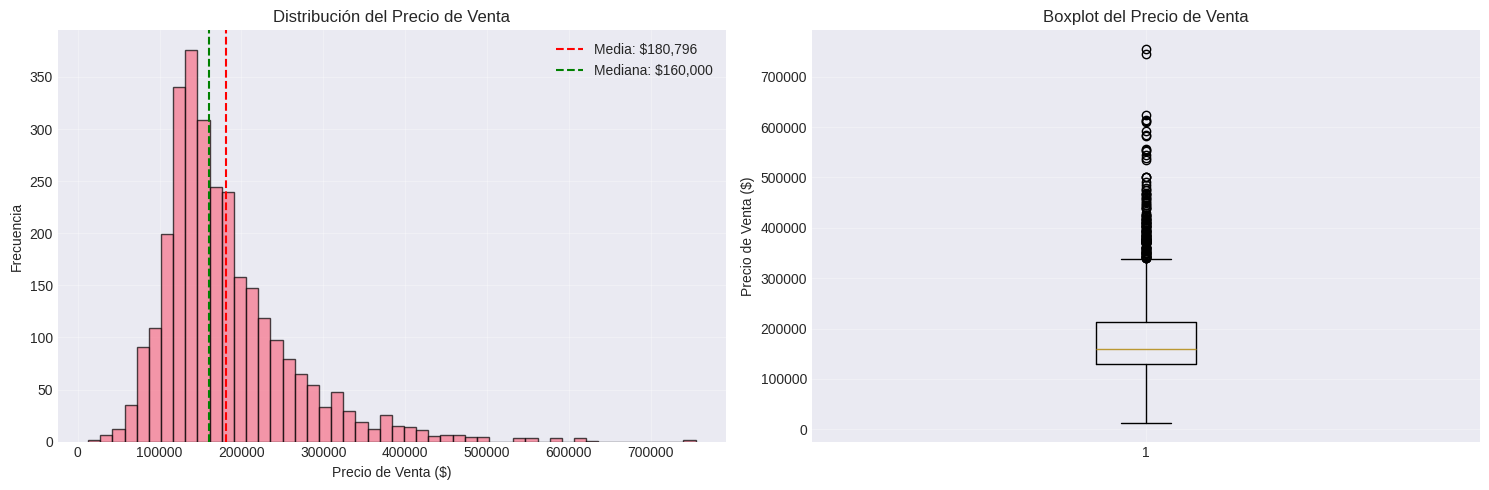

Asimetría (Skewness): 1.74
Curtosis (Kurtosis): 5.12


In [9]:
# Distribución del precio de venta
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma
axes[0].hist(df_housing['SalePrice'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(df_housing['SalePrice'].mean(), color='red', linestyle='--', label=f'Media: ${df_housing["SalePrice"].mean():,.0f}')
axes[0].axvline(df_housing['SalePrice'].median(), color='green', linestyle='--', label=f'Mediana: ${df_housing["SalePrice"].median():,.0f}')
axes[0].set_xlabel('Precio de Venta ($)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución del Precio de Venta')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
axes[1].boxplot(df_housing['SalePrice'], vert=True)
axes[1].set_ylabel('Precio de Venta ($)')
axes[1].set_title('Boxplot del Precio de Venta')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de asimetría
print(f"Asimetría (Skewness): {df_housing['SalePrice'].skew():.2f}")
print(f"Curtosis (Kurtosis): {df_housing['SalePrice'].kurtosis():.2f}")

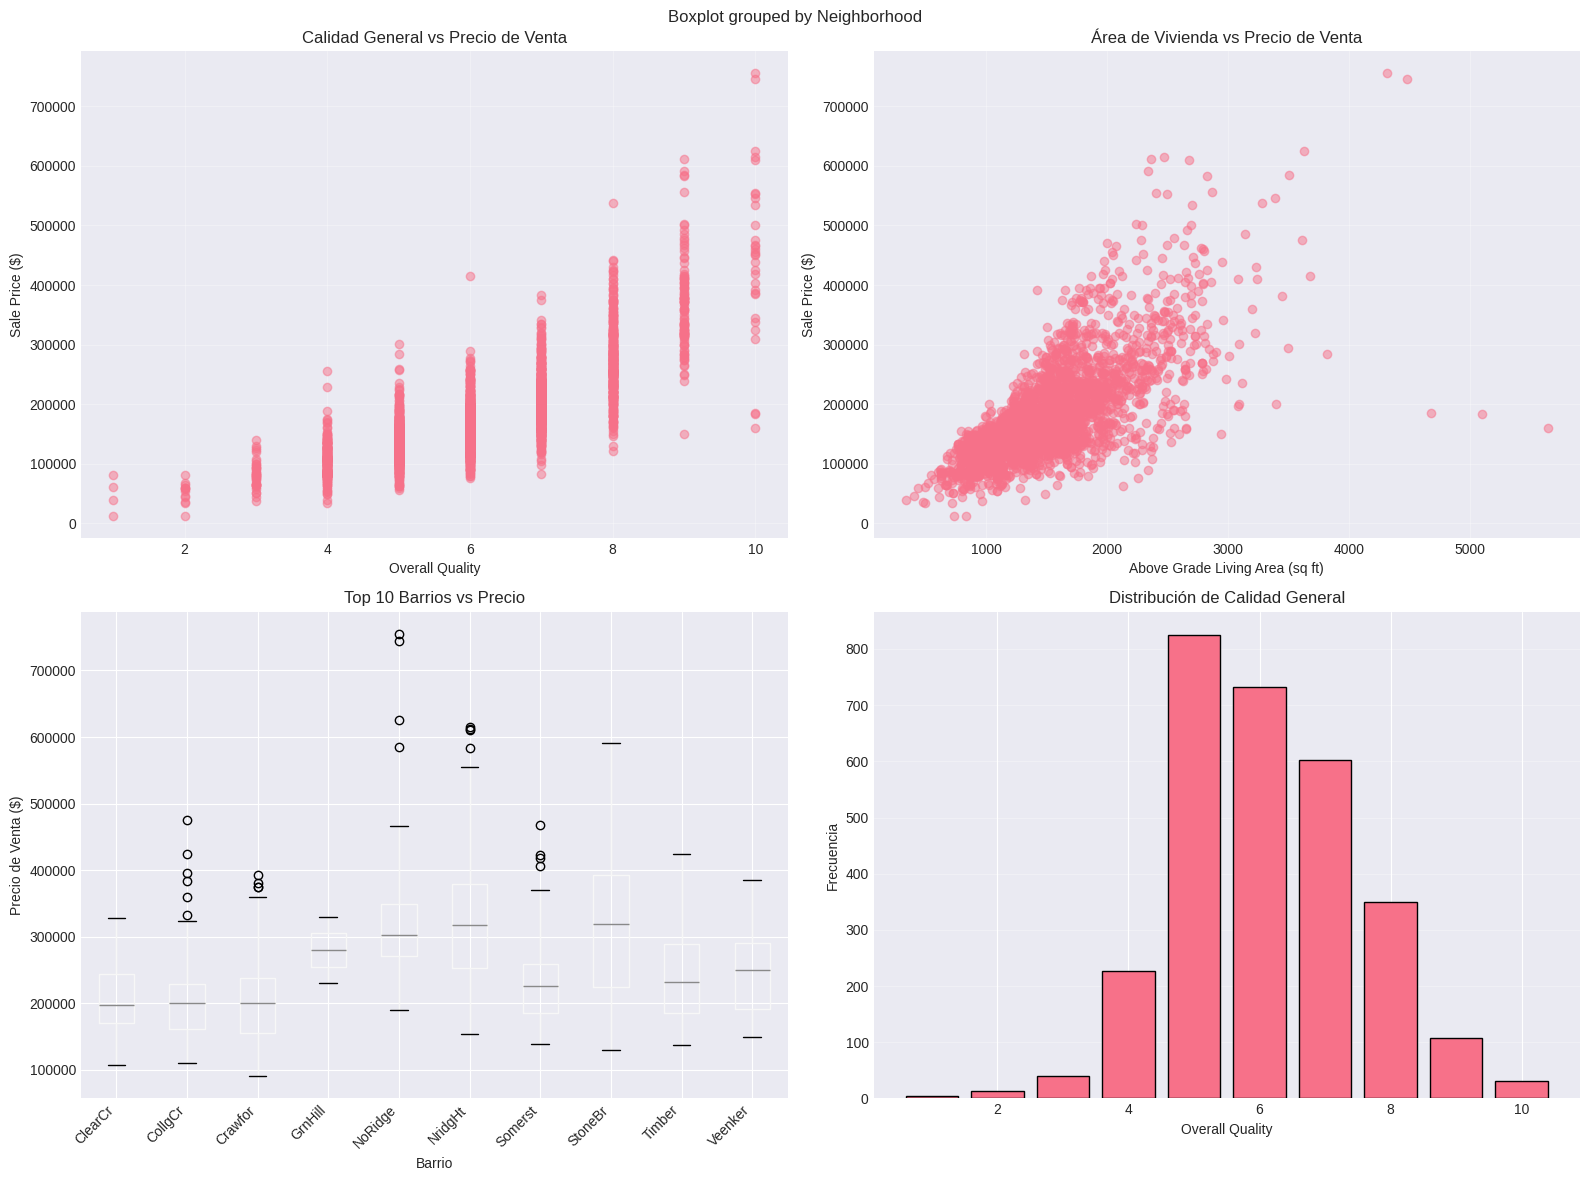

In [10]:
# Relación entre variables clave y precio
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Overall Quality vs Price
axes[0, 0].scatter(df_housing['Overall Qual'], df_housing['SalePrice'], alpha=0.5)
axes[0, 0].set_xlabel('Overall Quality')
axes[0, 0].set_ylabel('Sale Price ($)')
axes[0, 0].set_title('Calidad General vs Precio de Venta')
axes[0, 0].grid(True, alpha=0.3)

# Living Area vs Price
axes[0, 1].scatter(df_housing['Gr Liv Area'], df_housing['SalePrice'], alpha=0.5)
axes[0, 1].set_xlabel('Above Grade Living Area (sq ft)')
axes[0, 1].set_ylabel('Sale Price ($)')
axes[0, 1].set_title('Área de Vivienda vs Precio de Venta')
axes[0, 1].grid(True, alpha=0.3)

# Neighborhood vs Price (Top 10)
top_neighborhoods = neighborhood_stats.head(10).index
df_top = df_housing[df_housing['Neighborhood'].isin(top_neighborhoods)]
df_top.boxplot(column='SalePrice', by='Neighborhood', ax=axes[1, 0], rot=45)
axes[1, 0].set_xlabel('Barrio')
axes[1, 0].set_ylabel('Precio de Venta ($)')
axes[1, 0].set_title('Top 10 Barrios vs Precio')
plt.sca(axes[1, 0])
plt.xticks(rotation=45, ha='right')

# Overall Quality distribution
quality_counts = df_housing['Overall Qual'].value_counts().sort_index()
axes[1, 1].bar(quality_counts.index, quality_counts.values, edgecolor='black')
axes[1, 1].set_xlabel('Overall Quality')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Calidad General')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Matriz de Correlación - Variables Clave

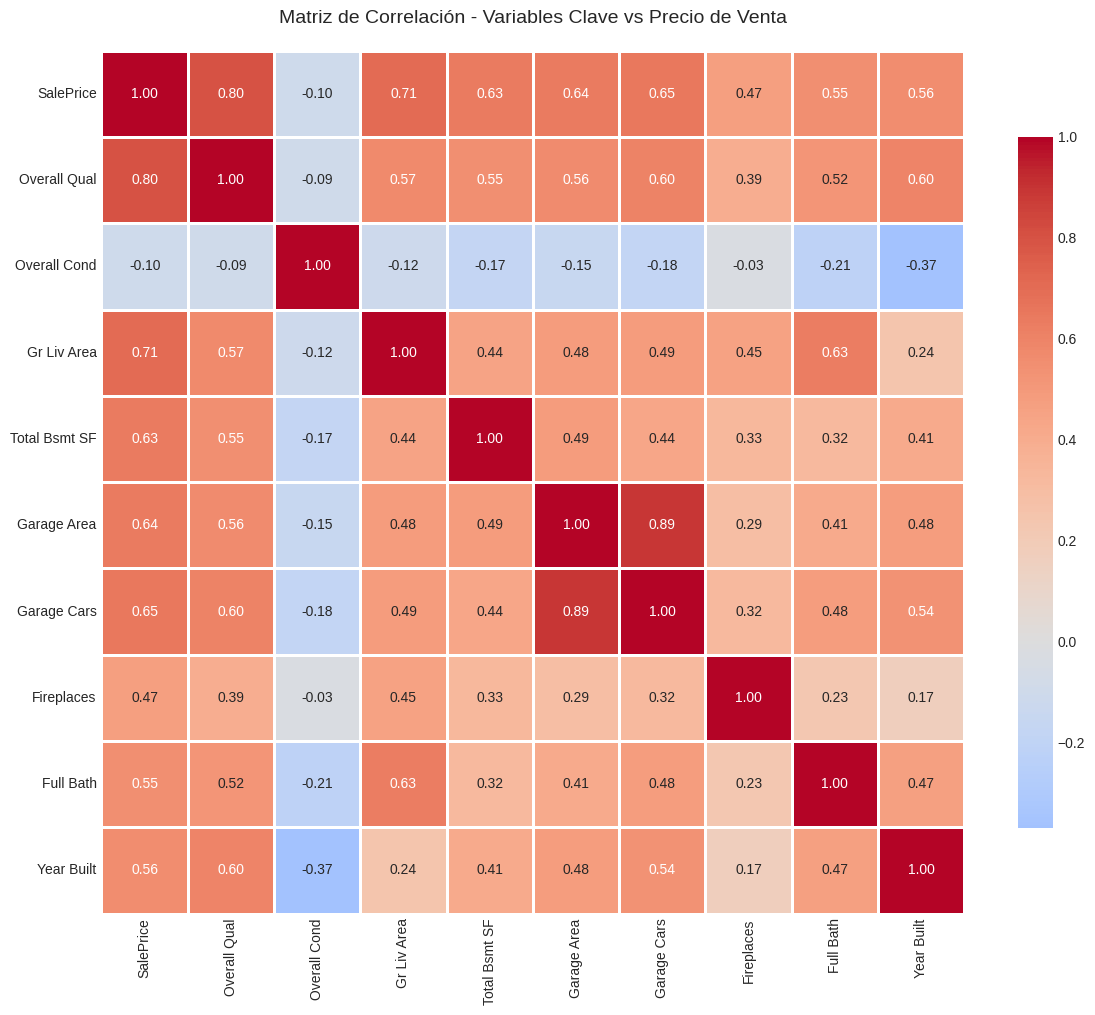


CORRELACIONES CON PRECIO DE VENTA
SalePrice        1.000000
Overall Qual     0.799262
Gr Liv Area      0.706780
Garage Cars      0.647877
Garage Area      0.640401
Total Bsmt SF    0.632280
Year Built       0.558426
Full Bath        0.545604
Fireplaces       0.474558
Overall Cond    -0.101697
Name: SalePrice, dtype: float64


In [11]:
# Seleccionar variables numéricas clave
numeric_key_vars = ['SalePrice', 'Overall Qual', 'Overall Cond', 'Gr Liv Area', 
                    'Total Bsmt SF', 'Garage Area', 'Garage Cars', 
                    'Fireplaces', 'Full Bath', 'Year Built']

# Matriz de correlación
corr_matrix = df_housing[numeric_key_vars].corr()

# Visualización
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Variables Clave vs Precio de Venta', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Top correlaciones con SalePrice
print("\n" + "=" * 80)
print("CORRELACIONES CON PRECIO DE VENTA")
print("=" * 80)
price_corr = corr_matrix['SalePrice'].sort_values(ascending=False)
print(price_corr)

## Construcción del Score Compuesto

### Metodología:

1. **Normalización**: Todas las variables se escalarán a un rango [0, 1]
2. **Ponderación**: Se aplicarán los pesos definidos por dimensión
3. **Agregación**: Score final = suma ponderada de las 4 dimensiones
4. **Clasificación**: Se definirá umbral basado en percentiles

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Función para convertir variables ordinales a numéricas
def ordinal_to_numeric(series, mapping):
    """Convierte variables ordinales categóricas a numéricas"""
    return series.map(mapping).fillna(0)

# Mapeos para variables ordinales de calidad
quality_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
bsmt_qual_map = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

# Crear copia del dataframe para trabajar
df_score = df_housing.copy()

# Convertir variables ordinales
df_score['Kitchen Qual_num'] = ordinal_to_numeric(df_score['Kitchen Qual'], quality_map)
df_score['Exter Qual_num'] = ordinal_to_numeric(df_score['Exter Qual'], quality_map)
df_score['Bsmt Qual_num'] = ordinal_to_numeric(df_score['Bsmt Qual'], bsmt_qual_map)

# Identificar barrios premium (top 25% por precio promedio)
top_neighborhoods = neighborhood_stats.head(int(len(neighborhood_stats) * 0.25)).index
df_score['Premium_Neighborhood'] = df_score['Neighborhood'].isin(top_neighborhoods).astype(int)

print("Variables ordinales convertidas:")
print(f"- Kitchen Qual: {df_score['Kitchen Qual_num'].describe()}")
print(f"\n- Exter Qual: {df_score['Exter Qual_num'].describe()}")
print(f"\n- Bsmt Qual: {df_score['Bsmt Qual_num'].describe()}")
print(f"\nBarrios Premium identificados: {len(top_neighborhoods)} de {len(neighborhood_stats)}")
print(f"Proporción de casas en barrios premium: {df_score['Premium_Neighborhood'].mean():.1%}")

Variables ordinales convertidas:
- Kitchen Qual: count    2930.000000
mean        3.511263
std         0.663162
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: Kitchen Qual_num, dtype: float64

- Exter Qual: count    2930.000000
mean        3.398635
std         0.580317
min         2.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: Exter Qual_num, dtype: float64

- Bsmt Qual: count    2930.000000
mean        3.478840
std         0.904295
min         0.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Bsmt Qual_num, dtype: float64

Barrios Premium identificados: 7 de 28
Proporción de casas en barrios premium: 19.4%


In [13]:
# Componente 1: CALIDAD GENERAL (35%)
scaler = MinMaxScaler()

calidad_vars = ['Overall Qual', 'Overall Cond']
df_score[calidad_vars] = df_score[calidad_vars].fillna(df_score[calidad_vars].median())
calidad_scaled = scaler.fit_transform(df_score[calidad_vars])

# Promedio ponderado: Overall Qual (70%), Overall Cond (30%)
score_calidad = calidad_scaled[:, 0] * 0.7 + calidad_scaled[:, 1] * 0.3

print("=" * 80)
print("SCORE DE CALIDAD GENERAL")
print("=" * 80)
print(f"Media: {score_calidad.mean():.3f}")
print(f"Std: {score_calidad.std():.3f}")
print(f"Min-Max: {score_calidad.min():.3f} - {score_calidad.max():.3f}")

SCORE DE CALIDAD GENERAL
Media: 0.567
Std: 0.114
Min-Max: 0.000 - 1.000


In [14]:
# Componente 2: TAMAÑO Y ESPACIOS (30%)
tamano_vars = ['Gr Liv Area', 'Total Bsmt SF', 'Garage Area', 'Lot Area']
df_score[tamano_vars] = df_score[tamano_vars].fillna(0)
tamano_scaled = scaler.fit_transform(df_score[tamano_vars])

# Ponderación: Gr Liv Area (40%), Total Bsmt (25%), Garage (20%), Lot (15%)
score_tamano = (tamano_scaled[:, 0] * 0.40 + 
                tamano_scaled[:, 1] * 0.25 + 
                tamano_scaled[:, 2] * 0.20 + 
                tamano_scaled[:, 3] * 0.15)

print("=" * 80)
print("SCORE DE TAMAÑO Y ESPACIOS")
print("=" * 80)
print(f"Media: {score_tamano.mean():.3f}")
print(f"Std: {score_tamano.std():.3f}")
print(f"Min-Max: {score_tamano.min():.3f} - {score_tamano.max():.3f}")

SCORE DE TAMAÑO Y ESPACIOS
Media: 0.201
Std: 0.071
Min-Max: 0.003 - 0.884


In [15]:
# Componente 3: UBICACIÓN PREMIUM (20%)
# Score basado en neighborhood premium
score_ubicacion = df_score['Premium_Neighborhood'].values.astype(float)

print("=" * 80)
print("SCORE DE UBICACIÓN PREMIUM")
print("=" * 80)
print(f"Media: {score_ubicacion.mean():.3f}")
print(f"Casas en ubicación premium: {score_ubicacion.sum():.0f} ({score_ubicacion.mean():.1%})")

SCORE DE UBICACIÓN PREMIUM
Media: 0.194
Casas en ubicación premium: 568 (19.4%)


In [16]:
# Componente 4: CARACTERÍSTICAS PREMIUM (15%)
premium_vars_num = ['Garage Cars', 'Fireplaces', 'Full Bath']
premium_vars_ord = ['Kitchen Qual_num', 'Exter Qual_num', 'Bsmt Qual_num']

# Normalizar variables numéricas
df_score[premium_vars_num] = df_score[premium_vars_num].fillna(0)
premium_num_scaled = scaler.fit_transform(df_score[premium_vars_num])

# Normalizar variables ordinales
premium_ord_scaled = scaler.fit_transform(df_score[premium_vars_ord])

# Combinar (50% numéricas, 50% ordinales)
score_premium_num = premium_num_scaled.mean(axis=1)
score_premium_ord = premium_ord_scaled.mean(axis=1)
score_premium = score_premium_num * 0.5 + score_premium_ord * 0.5

print("=" * 80)
print("SCORE DE CARACTERÍSTICAS PREMIUM")
print("=" * 80)
print(f"Media: {score_premium.mean():.3f}")
print(f"Std: {score_premium.std():.3f}")
print(f"Min-Max: {score_premium.min():.3f} - {score_premium.max():.3f}")

SCORE DE CARACTERÍSTICAS PREMIUM
Media: 0.447
Std: 0.120
Min-Max: 0.083 - 0.850


In [17]:
# SCORE COMPUESTO FINAL
# Pesos: Calidad (35%), Tamaño (30%), Ubicación (20%), Premium (15%)
df_score['Composite_Score'] = (score_calidad * 0.35 + 
                                score_tamano * 0.30 + 
                                score_ubicacion * 0.20 + 
                                score_premium * 0.15)

# Estadísticas del score compuesto
print("=" * 80)
print("SCORE COMPUESTO FINAL")
print("=" * 80)
print(df_score['Composite_Score'].describe())

# Percentiles
percentiles = [10, 25, 50, 75, 90, 95]
print("\nPercentiles:")
for p in percentiles:
    value = np.percentile(df_score['Composite_Score'], p)
    print(f"  P{p}: {value:.3f}")

SCORE COMPUESTO FINAL
count    2930.000000
mean        0.364646
std         0.132887
min         0.039354
25%         0.276975
50%         0.321677
75%         0.389186
max         0.789702
Name: Composite_Score, dtype: float64

Percentiles:
  P10: 0.246
  P25: 0.277
  P50: 0.322
  P75: 0.389
  P90: 0.606
  P95: 0.642


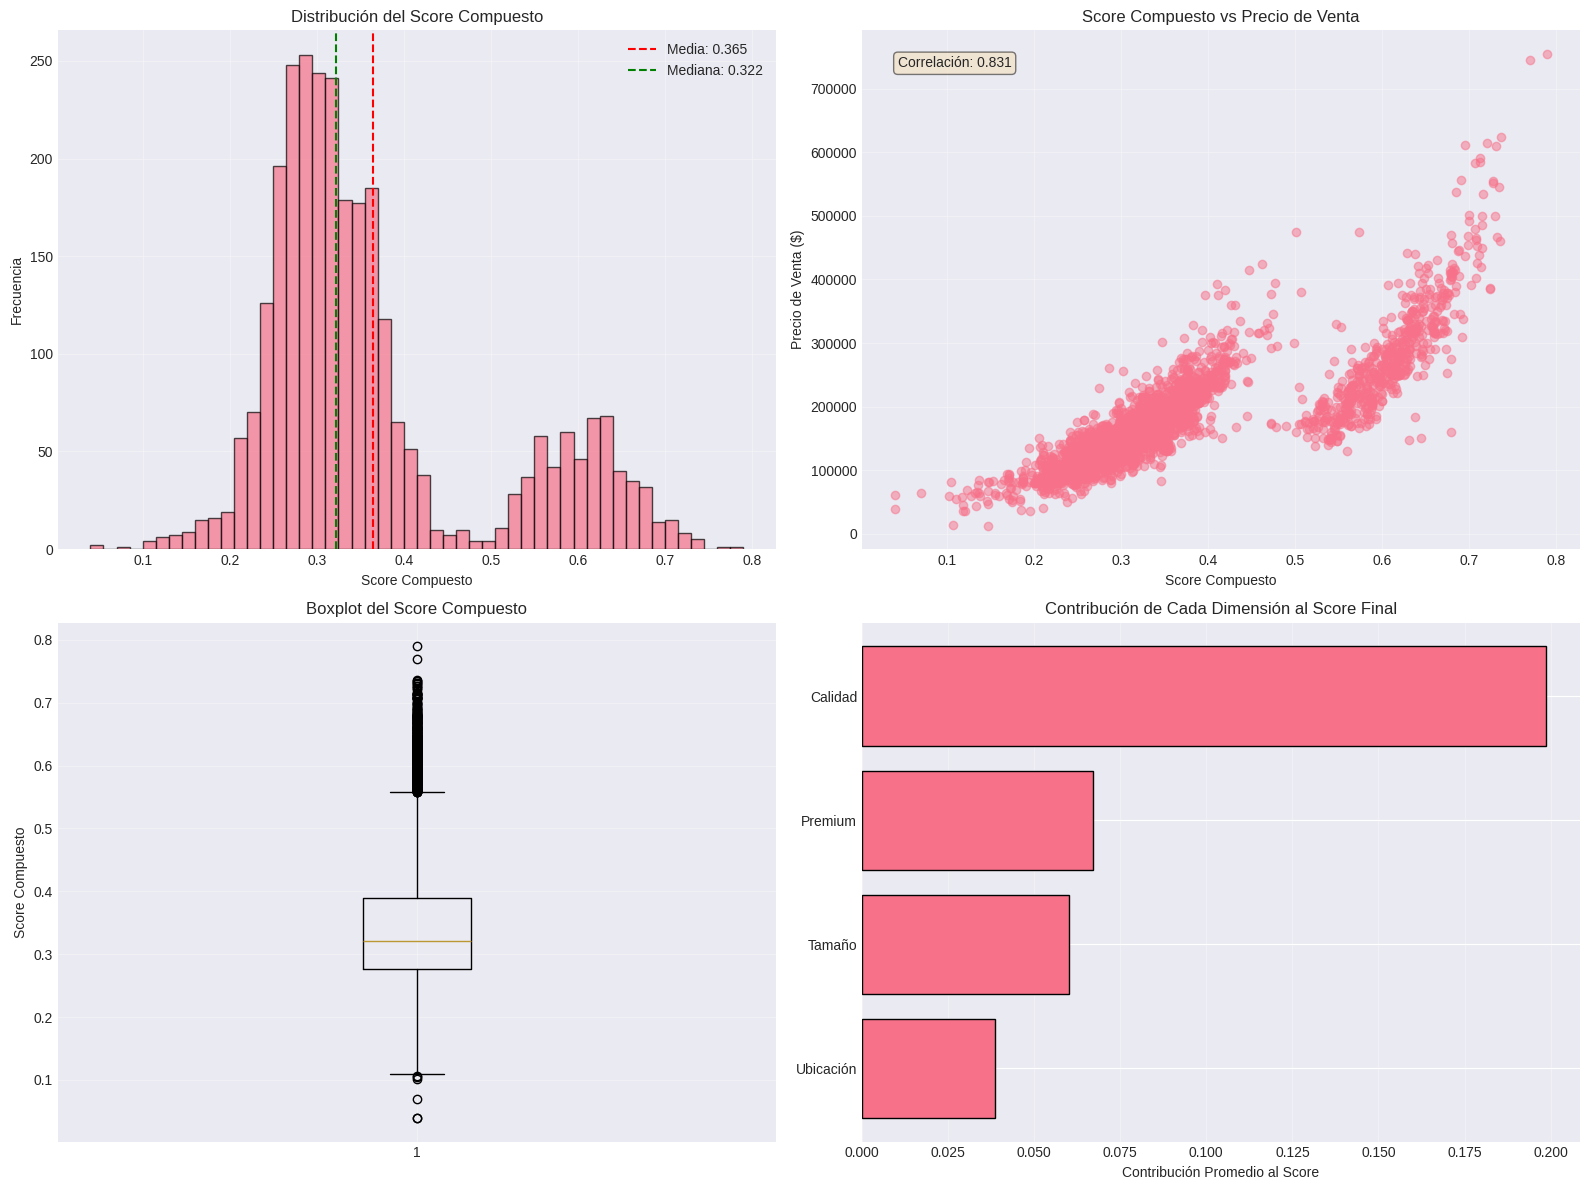

In [18]:
# Visualización del Score Compuesto
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribución del score
axes[0, 0].hist(df_score['Composite_Score'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_score['Composite_Score'].mean(), color='red', linestyle='--', 
                   label=f'Media: {df_score["Composite_Score"].mean():.3f}')
axes[0, 0].axvline(df_score['Composite_Score'].median(), color='green', linestyle='--', 
                   label=f'Mediana: {df_score["Composite_Score"].median():.3f}')
axes[0, 0].set_xlabel('Score Compuesto')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución del Score Compuesto')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Score vs Precio
axes[0, 1].scatter(df_score['Composite_Score'], df_score['SalePrice'], alpha=0.5)
axes[0, 1].set_xlabel('Score Compuesto')
axes[0, 1].set_ylabel('Precio de Venta ($)')
axes[0, 1].set_title('Score Compuesto vs Precio de Venta')
axes[0, 1].grid(True, alpha=0.3)

# Correlación entre score y precio
corr_score_price = df_score[['Composite_Score', 'SalePrice']].corr().iloc[0, 1]
axes[0, 1].text(0.05, 0.95, f'Correlación: {corr_score_price:.3f}', 
                transform=axes[0, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Boxplot
axes[1, 0].boxplot(df_score['Composite_Score'], vert=True)
axes[1, 0].set_ylabel('Score Compuesto')
axes[1, 0].set_title('Boxplot del Score Compuesto')
axes[1, 0].grid(True, alpha=0.3)

# Componentes del score
components = pd.DataFrame({
    'Calidad': score_calidad * 0.35,
    'Tamaño': score_tamano * 0.30,
    'Ubicación': score_ubicacion * 0.20,
    'Premium': score_premium * 0.15
})

components_mean = components.mean().sort_values(ascending=True)
axes[1, 1].barh(components_mean.index, components_mean.values, edgecolor='black')
axes[1, 1].set_xlabel('Contribución Promedio al Score')
axes[1, 1].set_title('Contribución de Cada Dimensión al Score Final')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### Definición de Clase Objetivo: "Alto Valor"

**Criterio propuesto:** Percentil 75 (Top 25%)

Justificación:
- Representa el cuartil superior de propiedades
- Balance entre clase minoritaria significativa y modelo entrenables
- Alineado con prácticas del mercado inmobiliario (propiedades premium)

In [19]:
# Definir umbral para "Alto Valor" (Percentil 75)
threshold_p75 = np.percentile(df_score['Composite_Score'], 75)

df_score['High_Value'] = (df_score['Composite_Score'] >= threshold_p75).astype(int)

# Estadísticas de la clasificación
print("=" * 80)
print("CLASIFICACIÓN: INMUEBLES DE ALTO VALOR")
print("=" * 80)
print(f"Umbral (P75): {threshold_p75:.3f}")
print(f"\nDistribución de clases:")
print(df_score['High_Value'].value_counts())
print(f"\nProporción:")
print(df_score['High_Value'].value_counts(normalize=True))

# Comparación de estadísticas entre clases
print("\n" + "=" * 80)
print("COMPARACIÓN ENTRE CLASES")
print("=" * 80)

comparison_vars = ['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Composite_Score']
comparison = df_score.groupby('High_Value')[comparison_vars].agg(['mean', 'median', 'std'])
print(comparison)

CLASIFICACIÓN: INMUEBLES DE ALTO VALOR
Umbral (P75): 0.389

Distribución de clases:
High_Value
0    2197
1     733
Name: count, dtype: int64

Proporción:
High_Value
0    0.749829
1    0.250171
Name: proportion, dtype: float64

COMPARACIÓN ENTRE CLASES
                SalePrice                         Overall Qual         \
                     mean    median           std         mean median   
High_Value                                                              
0           148603.639964  144000.0  42198.152899     5.537551    6.0   
1           277285.482947  261329.0  88095.411055     7.765348    8.0   

                      Gr Liv Area                     Composite_Score  \
                 std         mean  median         std            mean   
High_Value                                                              
0           1.044578  1359.474738  1324.0  402.796911        0.297365   
1           0.983220  1919.954980  1792.0  547.629643        0.566307   

                

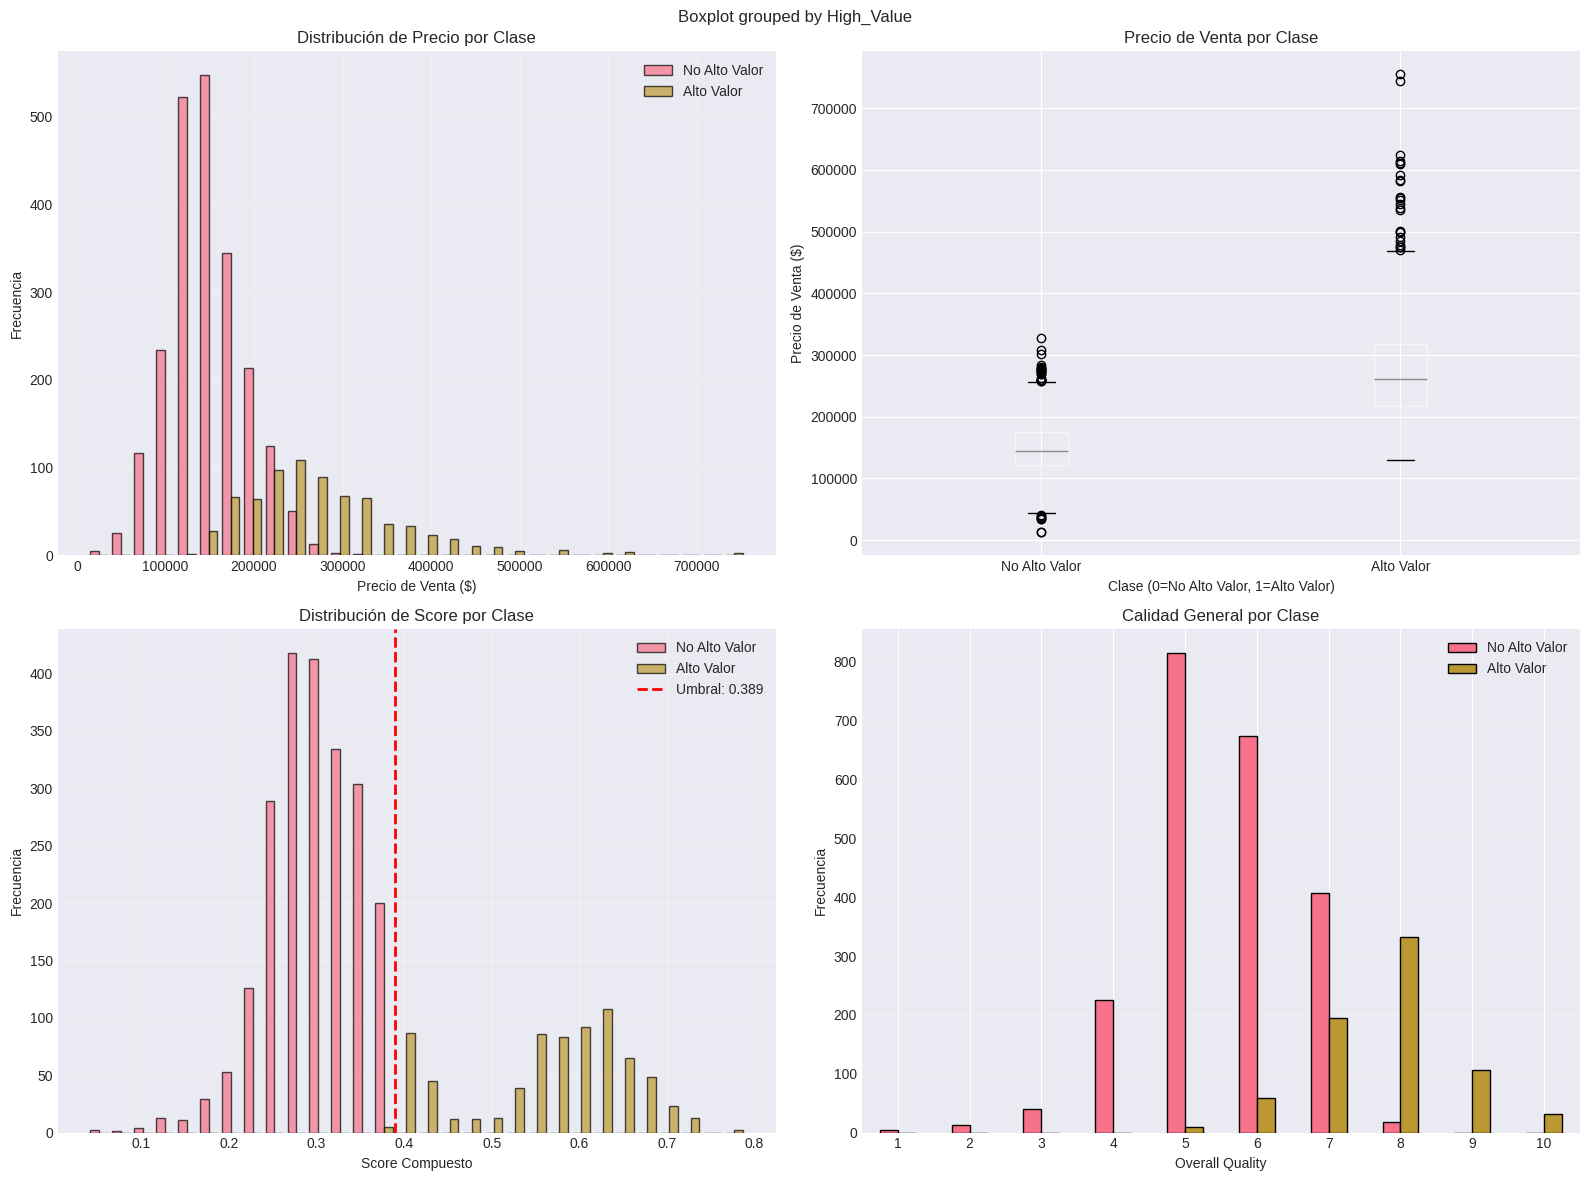

In [21]:
# Visualización de la clasificación
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribución de precio por clase
axes[0, 0].hist([df_score[df_score['High_Value']==0]['SalePrice'], 
                 df_score[df_score['High_Value']==1]['SalePrice']], 
                label=['No Alto Valor', 'Alto Valor'], 
                bins=30, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Precio de Venta ($)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución de Precio por Clase')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Boxplot de precio por clase
df_score.boxplot(column='SalePrice', by='High_Value', ax=axes[0, 1])
axes[0, 1].set_xlabel('Clase (0=No Alto Valor, 1=Alto Valor)')
axes[0, 1].set_ylabel('Precio de Venta ($)')
axes[0, 1].set_title('Precio de Venta por Clase')
plt.sca(axes[0, 1])
plt.xticks([1, 2], ['No Alto Valor', 'Alto Valor'])

# Score por clase
axes[1, 0].hist([df_score[df_score['High_Value']==0]['Composite_Score'], 
                 df_score[df_score['High_Value']==1]['Composite_Score']], 
                label=['No Alto Valor', 'Alto Valor'], 
                bins=30, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(threshold_p75, color='red', linestyle='--', linewidth=2, 
                   label=f'Umbral: {threshold_p75:.3f}')
axes[1, 0].set_xlabel('Score Compuesto')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Distribución de Score por Clase')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Overall Quality por clase
quality_by_class = df_score.groupby(['High_Value', 'Overall Qual']).size().unstack(fill_value=0)
quality_by_class.T.plot(kind='bar', ax=axes[1, 1], edgecolor='black')
axes[1, 1].set_xlabel('Overall Quality')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Calidad General por Clase')
axes[1, 1].legend(['No Alto Valor', 'Alto Valor'])
axes[1, 1].grid(True, alpha=0.3, axis='y')
plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

## Resumen de la Propuesta

### Score Compuesto Implementado

**Fórmula:**
```
Score_Compuesto = 0.35 × Score_Calidad + 
                  0.30 × Score_Tamaño + 
                  0.20 × Score_Ubicación + 
                  0.15 × Score_Premium
```

**Donde:**

1. **Score_Calidad** = 0.70 × Overall_Qual_norm + 0.30 × Overall_Cond_norm
2. **Score_Tamaño** = 0.40 × GrLivArea_norm + 0.25 × TotalBsmt_norm + 0.20 × GarageArea_norm + 0.15 × LotArea_norm
3. **Score_Ubicación** = Barrio_Premium (binario: 1 si está en top 25% de barrios, 0 si no)
4. **Score_Premium** = 0.50 × (promedio de Garage_Cars, Fireplaces, Full_Bath normalizados) + 0.50 × (promedio de Kitchen_Qual, Exter_Qual, Bsmt_Qual normalizados)

### Clasificación Binaria

- **Clase 1 (Alto Valor):** Score_Compuesto ≥ Percentil 75
- **Clase 0 (No Alto Valor):** Score_Compuesto < Percentil 75

### Ventajas de este Enfoque

1. ✅ **Interpretabilidad:** Cada componente tiene significado claro para stakeholders
2. ✅ **Robustez:** No depende exclusivamente del precio de mercado
3. ✅ **Generalización:** Puede aplicarse a mercados con diferentes niveles de precios
4. ✅ **Balance:** Distribución 75/25 permite entrenar modelos efectivos
5. ✅ **Basado en características intrínsecas:** Menos susceptible a fluctuaciones temporales

### Próximos Pasos

1. Validar la correlación score-precio en diferentes segmentos
2. Análisis de valores faltantes en variables clave
3. Feature engineering adicional
4. Preparación de datos para modelado

In [ ]:
# Guardar dataset con score y clasificación
output_path = DATA_PATH / "processed" / "housing_with_score.csv"
df_score.to_csv(output_path, index=False)
print(f"Dataset procesado guardado en: {output_path}")
print(f"Shape: {df_score.shape}")
print(f"\nNuevas columnas creadas:")
print("  - Composite_Score: Score compuesto [0, 1]")
print("  - High_Value: Clasificación binaria (1=Alto Valor, 0=No Alto Valor)")
print("  - Premium_Neighborhood: Indicador de barrio premium")
print("  - Kitchen Qual_num, Exter Qual_num, Bsmt Qual_num: Variables ordinales numéricas")

Dataset procesado guardado en: ../data/processed/housing_with_score.csv
Shape: (2930, 88)

Nuevas columnas creadas:
  - Composite_Score: Score compuesto [0, 1]
  - High_Value: Clasificación binaria (1=Alto Valor, 0=No Alto Valor)
  - Premium_Neighborhood: Indicador de barrio premium
  - Kitchen Qual_num, Exter Qual_num, Bsmt Qual_num: Variables ordinales numéricas


: 